In [19]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
import phantom_builder
from core import *
import open3d as o3d
from open3d import io, visualization

from sklearn.cluster import KMeans
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage import segmentation 

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob
import pydicom
import functools
import mcubes

# code below is commented out since we start with a re-scaled and re-positioned body surface mesh from kidney_files directory

# def plot_slice(image, slice):
#     plt.imshow(image[:, :, slice])
#     plt.colorbar()
#     plt.gray()

#image, voxel_size = phantom_builder.read_dicom('../demos/series-00000/', HU = True, crop = 450, axis = 0)
# opened = phantom_builder.morph_open(image, 5)
# fg_mask = phantom_builder.make_fg_mask(opened, opened.shape[2], fg_threshold = 40)
# fg_mask = phantom_builder.make_fg_mask(opened, opened.shape[2], fg_threshold = 40)
# vertices, triangles = phantom_builder.make_surface_mesh(fg_mask, voxel_size, './abdomen_smoothed.obj')


In [20]:
voxel_size = np.array([0.00058984, 0.00058984, 0.0005])
surface_mesh = io.read_triangle_mesh("../demos/abdomen_smoothed_scaled.obj")

# idx = [0,1,2]
# np.array(surface_mesh.vertices)[:,idx]
# points = o3d.utility.Vector3dVector(np.array(surface_mesh.vertices)[:,idx])
# surface_mesh.vertices = points

body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh) 

In [40]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=1.3, scale=0.00001, label=1)
medulla = tissue.Tissue(name='renal_medulla', c=1564, rho=1044, sigma=40, scale=0.0001, label=2)
cortex = tissue.Tissue(name='renal_cortex', c=1571.3, rho=1049, sigma=5, scale=0.0001, label=3)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=4)
connective = tissue.Tissue(name='connective_tissue', c=1450, rho=1027, sigma=30, scale=0.0001, label=5)

kidney_file_dir = "../demos/kidney_files/"
kidney_tissue_list = [connective, cortex, blood, blood, medulla]

test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
#test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)

test_phantom.add_tissue_sphere((0.02, 0.073, -0.09), 20, cortex)

test_phantom.add_tissue_sphere((0, 0, 0), 20, cortex)

#tissue sphere is not being added at the specified spot and is instead going to origin; check method to create


#test_phantom.add_tissue_sphere((0.02, 0.073, -0.07), 50, cortex)

test_phantom.set_default_tissue('fat')

(385, 347, 84)
(351, 224, 237)


In [22]:
# test_phantom.mask = np.transpose(test_phantom.mask, (2, 0, 1) )
# test_phantom.matrix_dims = np.array(test_phantom.mask.shape)
# test_phantom.voxel_dims = np.array([test_phantom.voxel_dims[2] , test_phantom.voxel_dims[0], test_phantom.voxel_dims[1]])
test = test_phantom.get_complete()

print(test.shape)


(2, 703, 448, 475)


In [23]:
print(test_phantom.matrix_dims)
print(test_phantom.voxel_dims)

[703 448 475]
[0.00058984 0.00058984 0.00058984]


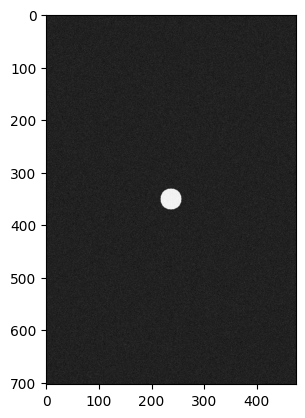

In [25]:
slice = 224
plt.imshow(test[0, :, slice, :])
#bm = np.transpose(body_mask, (2, 0,1))
#plt.imshow(bm[:,:, slice] * 1000, alpha=0.2, cmap='Reds_r')

In [26]:
num_transducers = 1
# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 32, 
#                                     width = 20e-3,
#                                     height =  20e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/3,
#                                     ray_num = 3, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 20e-3,
#                                     ) for i in range(num_transducers)]

transducers = [transducer.Focused(max_frequency = 0.5e6,
                                  elements = 32, 
                                  width = 20e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/3,
                                  ray_num = 3,
                                  imaging_ndims = 2,
                                  focus_azimuth = 100e-3,
                                  focus_elevation = 100e-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

# place point at [30, 550, 350] on image; need to permute input to place_transducer_by_voxel because i built the .obj files in a dumb manner

pt, normal = test_transducer_set.place_transducer_by_voxel(0, surface_mesh,[400,350,50], voxel_size[0])
pt = np.array([pt[2], pt[0], pt[1]])
normal = -np.array([normal[2] , normal[0], normal[1]])
theta = np.pi/100
print(normal)
print(theta*normal)
print(pt)
#test_transducer_set.assign_pose(0, geometry.Transform(translation=pt, rot_vec = False))

test_transducer_set.assign_pose(0, geometry.Transform(translation=(0,0,0), rot_vec=False))

#test_transducer_set.assign_pose(0, geometry.Transform(rotation=theta*normal, translation=pt, rot_vec = True))



[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
[0.8413283  0.52805525 0.11543145]
[0.02643111 0.01658935 0.00362639]
[-0.12109327  0.02219937  0.07306117]


In [9]:
mesh = o3d.io.read_triangle_mesh('../demos/kidney_files/1_kidney_capsule.obj')
#mesh = o3d.io.read_triangle_mesh('../demos/abdomen_smoothed_scaled.obj')
pcd = o3d.geometry.PointCloud()
pcd.points = mesh.vertices
pcd.colors = mesh.vertex_colors
pcd.normals = mesh.vertex_normals

In [10]:
capsule_pc = np.array(pcd.points)

min_coord = surface_mesh.get_min_bound()
max_coord = surface_mesh.get_max_bound()
mesh_origin = np.mean([min_coord, max_coord], axis=0)

print(mesh_origin)

translate = np.broadcast_to(mesh_origin, capsule_pc.shape)

capsule_pc = capsule_pc - translate

idx = [2, 0, 1]
capsule_pc = capsule_pc[:,idx]




[-0.002775   0.2549285  0.008644 ]


NameError: name 'capsule_pc' is not defined

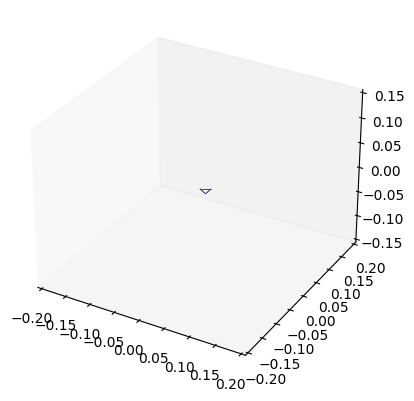

In [27]:
test_transducer_set.plot_transducer_fovs(scale=0.2)
test_transducer_set.plot_transducer_coords(scale=0.2, phantom_coords=capsule_pc)



[-0.12109327  0.02219937  0.07306117]
[0.8413283  0.52805525 0.11543145]
(5631, 3)
(519, 3)


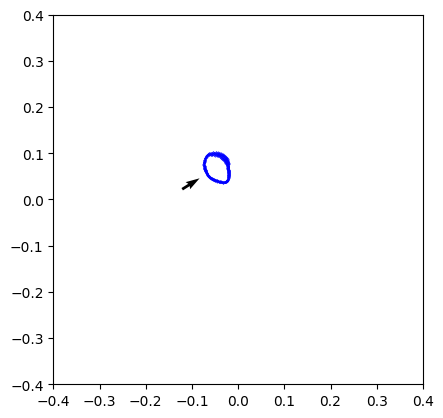

In [12]:

scale = 0.4

fig, ax = plt.subplots()
#ax = fig.add_subplot(projection='3d')
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
#ax.set_zlim(-scale, scale)
ax.set_aspect('equal')
ax.grid(False)

phantom_coords = capsule_pc

print(pt)
print(normal)
#ax.quiver(pt[0], pt[1], pt[2], normal[0], normal[1], normal[2], color = 'r')

z_coord_bools = []

print(phantom_coords.shape)

for coord in phantom_coords:
    z_coord_bools.append(coord[2] > 0.07 and coord[2] < 0.08)
    
#print(z_coord_bools)

filtered = phantom_coords[z_coord_bools]

print(filtered.shape)

# #ax.scatter(phantom_coords[:,0], phantom_coords[:,1], phantom_coords[:,2], s=0.1, color='b')
ax.scatter(filtered[:, 0], filtered[:,1], s=0.1, color='b')

ax.quiver(pt[0], pt[1], normal[0], normal[1])





In [29]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [30]:
print(test_sensor.sensor_coords)

print(np.mean(test_sensor.sensor_coords, axis=0))

[[ 0.         -0.0096875  -0.01      ]
 [ 0.         -0.0096875  -0.00818182]
 [ 0.         -0.0096875  -0.00636364]
 ...
 [ 0.          0.0096875   0.00636364]
 [ 0.          0.0096875   0.00818182]
 [ 0.          0.0096875   0.01      ]]
[0. 0. 0.]


66802


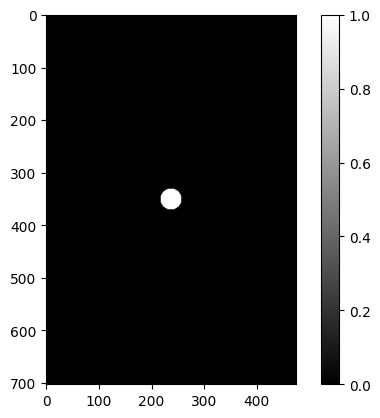

In [32]:
#test_sensor.visualize(test_phantom, slice)

def visualize(sensor, phantom, slice, body_surface_mask = None):
        global_mask = np.zeros(phantom.mask.shape)
        global_mask = np.where(np.ndarray.astype(phantom.mask, int) != phantom.default_tissue, 1, 0)
        print(np.sum(global_mask))
        sensor_voxels = np.divide(sensor.sensor_coords, phantom.voxel_dims)
        phantom_centroid = np.array(phantom.mask.shape)/2 
        recenter_matrix = np.broadcast_to(phantom_centroid, sensor_voxels.shape)
        sensor_voxels = sensor_voxels + recenter_matrix
        sensor_voxels_disc = np.ndarray.astype(np.round(sensor_voxels), int)
        for voxel in sensor_voxels_disc:
            global_mask[voxel[0], voxel[1], voxel[2]] = 1
        
        if body_surface_mask is not None:
            global_mask = global_mask + body_surface_mask

        plt.imshow(global_mask[:, slice, :])
        plt.colorbar()
        plt.gray()

visualize(test_sensor, test_phantom, slice-1)

In [41]:
simprops = simulation.SimProperties(
                grid_size   = (200e-3,40e-3,40e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (8,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [42]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/kidney_experiment_01',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

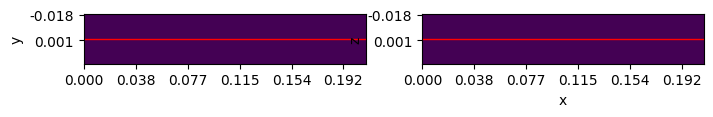

In [43]:
test_experiment.plot_ray_path(0)

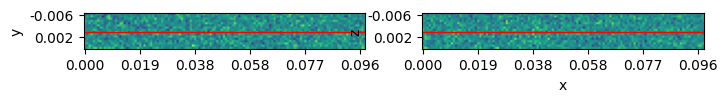

In [36]:
test_experiment.plot_ray_path(1)

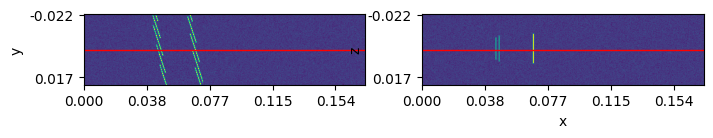

In [43]:
test_experiment.plot_ray_path(2)

In [44]:
test_experiment = experiment.Experiment.load('../experiment_files/kidney_experiment_01')
test_experiment.run(dry=True)

Number of simulation results (0) is less than the expected number of simulation results (3), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


In [ ]:
test_experiment.run(repeat=True)